**Installing packages and libraries**

In [2]:
# Install xgboost
!pip install xgboost

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings('ignore')


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\karis\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Loading and processing the data**

In [4]:
# Load data
df = pd.read_csv(r"C:\Users\karis\Financial-Risk-Pipeline-for-P2P-Lending-Investments\enhanced_featured_data.csv")
print("Shape of dataset:", df.shape)
print("\nFirst few rows of dataset:")
print(df.head())

# Drop identifiers and date-related columns not useful for modeling
drop_cols = [
    'listingkey', 'listingcreationdate', 'borrowerstate', 'occupation',
    'datecreditpulled', 'firstrecordedcreditline', 'loankey',
    'loanoriginationdate', 'loanoriginationquarter', 'memberkey'
]

# Define features (X) and target (y)
X = df.drop(columns=drop_cols + ['loan_status_binary'])
y = df['loan_status_binary']

X = df.drop(columns=drop_cols + ['loan_status_binary'])
y = df['loan_status_binary']

# Check for NaNs in y
print("\nMissing values in target (y):", y.isna().sum())
if y.isna().sum() > 0:
    print("Dropping rows with NaN in target variable...")
    # Drop rows where y is NaN
    valid_idx = y.notna()
    X = X[valid_idx]
    y = y[valid_idx]
    print("New shape of X:", X.shape)
    print("New shape of y:", y.shape)

# Check for NaNs in X
print("\nMissing values in features (X):")
print(X.isna().sum())

# Impute NaNs in X with median for numerical columns
X = X.fillna(X.median(numeric_only=True))
# If any non-numeric columns have NaNs, consider dropping or imputing with mode
for col in X.select_dtypes(include=['object']).columns:
    if X[col].isna().sum() > 0:
        X[col] = X[col].fillna(X[col].mode()[0])
print("\nMissing values in X after imputation:")
print(X.isna().sum())

Shape of dataset: (113932, 98)

First few rows of dataset:
                listingkey  listingnumber listingcreationdate  term  \
0  1021339766868145413AB3B       193129.0          2007-08-26    36   
1  10273602499503308B223C1      1209647.0          2014-02-27    36   
2  0EE9337825851032864889A        81716.0          2007-01-05    36   
3  0EF5356002482715299901A       658116.0          2012-10-22    36   
4  0F023589499656230C5E3E2       909464.0          2013-09-14    36   

   borrowerapr  prosperrating_numeric  prosperscore  listingcategory_numeric  \
0    -0.670818                    4.0      0.444444                        0   
1    -1.233444                    6.0      0.555556                        2   
2     0.798634                    4.0      0.444444                        0   
3    -1.169430                    6.0      0.777778                       16   
4     0.341657                    3.0      0.222222                        2   

  borrowerstate     occupation  .

**Creating hold-out test set**

In [5]:
# 1. Create Hold-out Test Set (70% train, 15% validation, 15% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)  # 0.1765 = 15/(100-15)

print("\nTraining samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 79749
Validation samples: 17093
Testing samples: 17090


**Checking and handlling class imbalance**

In [6]:
# 3. Check Target Variable Distribution
print("\nTarget Variable Distribution in Training Set:")
print(y_train.value_counts(normalize=True))
print("\nTarget Variable Distribution in Validation Set:")
print(y_val.value_counts(normalize=True))
print("\nTarget Variable Distribution in Test Set:")
print(y_test.value_counts(normalize=True))

# 4. Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Convert X_train_smote to DataFrame to preserve column names
X_train_smote = pd.DataFrame(X_train_smote, columns=X_train.columns)
print("\nTarget Variable Distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts(normalize=True))


Target Variable Distribution in Training Set:
loan_status_binary
0    0.841954
1    0.158046
Name: proportion, dtype: float64

Target Variable Distribution in Validation Set:
loan_status_binary
0    0.841982
1    0.158018
Name: proportion, dtype: float64

Target Variable Distribution in Test Set:
loan_status_binary
0    0.841954
1    0.158046
Name: proportion, dtype: float64

Target Variable Distribution after SMOTE:
loan_status_binary
0    0.5
1    0.5
Name: proportion, dtype: float64


**Defining Evaluation functions**

In [7]:
#Define Evaluation Function
def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_proba):.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(y_true, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

**K fold validation**


XGBoost Cross-Validation Results (Mean ± Std):
Accuracy: 0.9998 ± 0.0001
Precision: 0.9999 ± 0.0001
Recall: 0.9997 ± 0.0002
F1: 0.9998 ± 0.0001
Roc_auc: 1.0000 ± 0.0000

XGBoost Performance Comparison:
Training Set:

XGBoost Training Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     67145
           1       1.00      1.00      1.00     67145

    accuracy                           1.00    134290
   macro avg       1.00      1.00      1.00    134290
weighted avg       1.00      1.00      1.00    134290



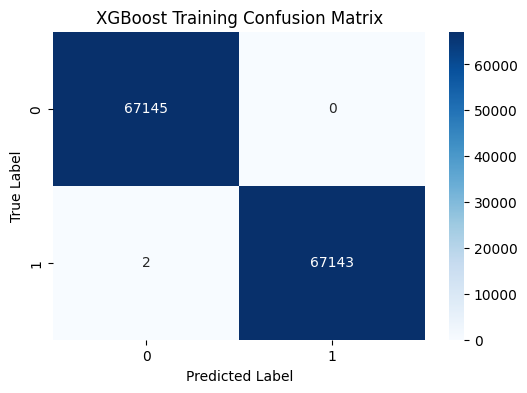

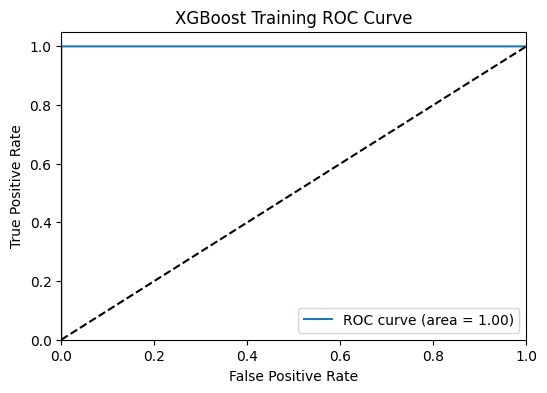

Test Set:

XGBoost Test Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14389
           1       1.00      1.00      1.00      2701

    accuracy                           1.00     17090
   macro avg       1.00      1.00      1.00     17090
weighted avg       1.00      1.00      1.00     17090



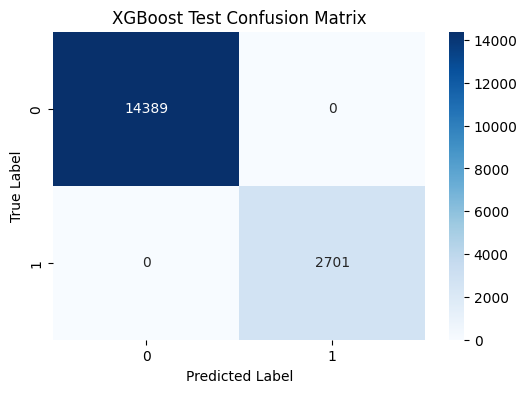

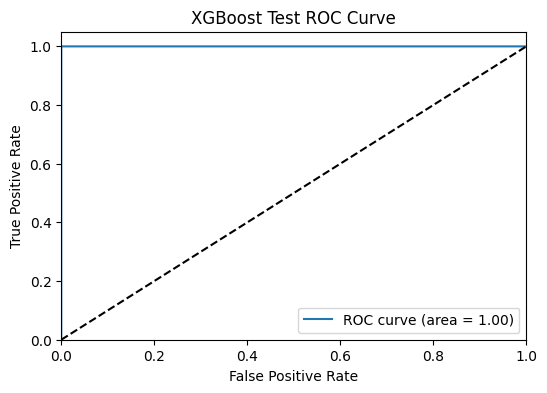

Model saved as xgboost_final_model.pkl


In [8]:
# 6. Stratified K-Fold Cross-Validation for XGBoost
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# XGBoost Cross-Validation
xgb_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

for train_idx, val_idx in skf.split(X_train_smote, y_train_smote):
    X_tr, X_val = X_train_smote.iloc[train_idx], X_train_smote.iloc[val_idx]
    y_tr, y_val = y_train_smote[train_idx], y_train_smote[val_idx]

    xgb.fit(X_tr, y_tr)
    y_pred = xgb.predict(X_val)
    y_proba = xgb.predict_proba(X_val)[:, 1]

    xgb_scores['accuracy'].append(accuracy_score(y_val, y_pred))
    xgb_scores['precision'].append(precision_score(y_val, y_pred))
    xgb_scores['recall'].append(recall_score(y_val, y_pred))
    xgb_scores['f1'].append(f1_score(y_val, y_pred))
    xgb_scores['roc_auc'].append(roc_auc_score(y_val, y_proba))

print("\nXGBoost Cross-Validation Results (Mean ± Std):")
for metric, scores in xgb_scores.items():
    print(f"{metric.capitalize()}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# 7. Train Final XGBoost Model and Compare Training vs. Testing Performance
xgb.fit(X_train_smote, y_train_smote)
xgb_train_pred = xgb.predict(X_train_smote)
xgb_train_proba = xgb.predict_proba(X_train_smote)[:, 1]
xgb_test_pred = xgb.predict(X_test)
xgb_test_proba = xgb.predict_proba(X_test)[:, 1]

print("\nXGBoost Performance Comparison:")
print("Training Set:")
evaluate_model(y_train_smote, xgb_train_pred, xgb_train_proba, "XGBoost Training")
print("Test Set:")
evaluate_model(y_test, xgb_test_pred, xgb_test_proba, "XGBoost Test")

import pickle

# Save the trained XGBoost model to a .pkl file
with open("xgboost_final_model.pkl", "wb") as file:
    pickle.dump(xgb, file)

print("Model saved as xgboost_final_model.pkl")


**Training vs testing**


XGBoost Performance Comparison:
Training Set:

XGBoost Training Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     46228
           1       1.00      1.00      1.00     46228

    accuracy                           1.00     92456
   macro avg       1.00      1.00      1.00     92456
weighted avg       1.00      1.00      1.00     92456



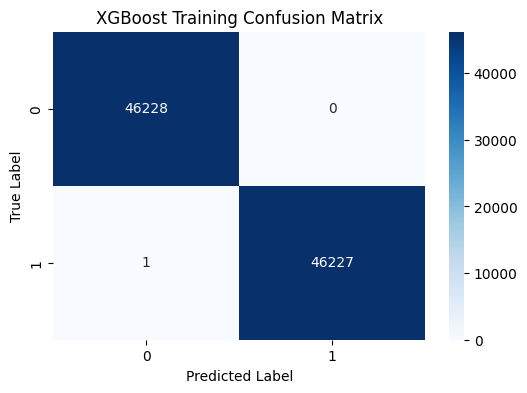

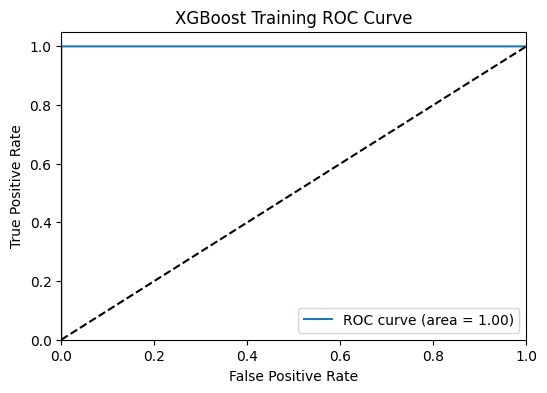

Test Set:

XGBoost Test Evaluation:
Accuracy: 0.9999
Precision: 1.0000
Recall: 0.9995
F1-Score: 0.9997
ROC-AUC: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9907
           1       1.00      1.00      1.00      1856

    accuracy                           1.00     11763
   macro avg       1.00      1.00      1.00     11763
weighted avg       1.00      1.00      1.00     11763



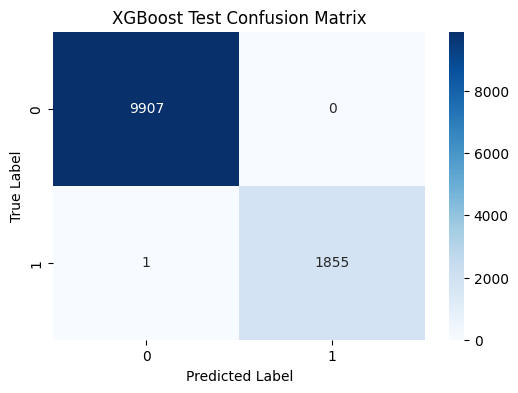

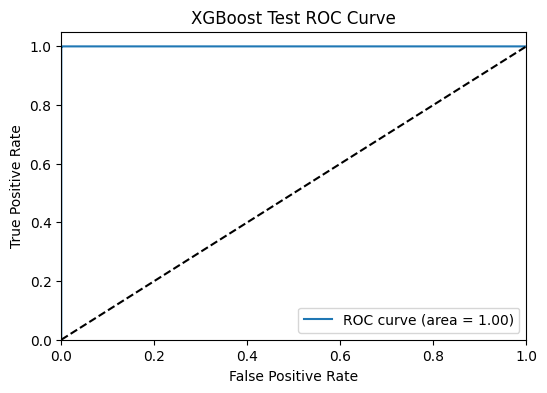

In [17]:
# 6. Train Final XGBoost Model and Compare Training vs. Testing Performance
xgb.fit(X_train_smote, y_train_smote)
xgb_train_pred = xgb.predict(X_train_smote)
xgb_train_proba = xgb.predict_proba(X_train_smote)[:, 1]
xgb_test_pred = xgb.predict(X_test)
xgb_test_proba = xgb.predict_proba(X_test)[:, 1]

print("\nXGBoost Performance Comparison:")
print("Training Set:")
evaluate_model(y_train_smote, xgb_train_pred, xgb_train_proba, "XGBoost Training")
print("Test Set:")
evaluate_model(y_test, xgb_test_pred, xgb_test_proba, "XGBoost Test")

**Feature imortance**

<Figure size 1000x600 with 0 Axes>

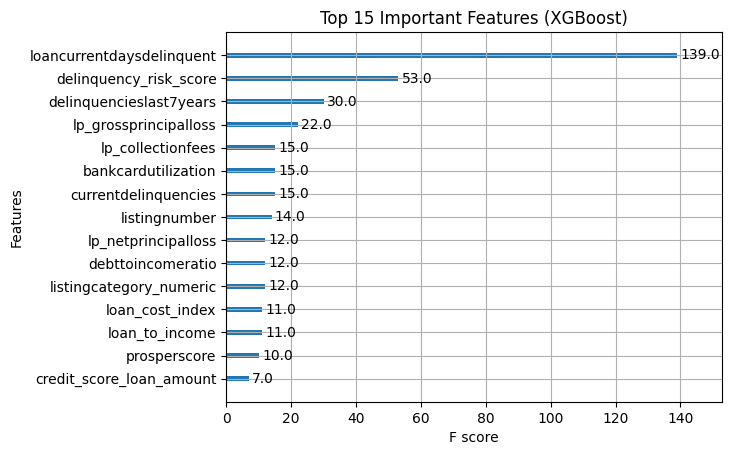

In [18]:
# 7. Feature Importance for XGBoost
plt.figure(figsize=(10, 6))
plot_importance(xgb, max_num_features=15)
plt.title("Top 15 Important Features (XGBoost)")
plt.show()


**SHAP Explainer**

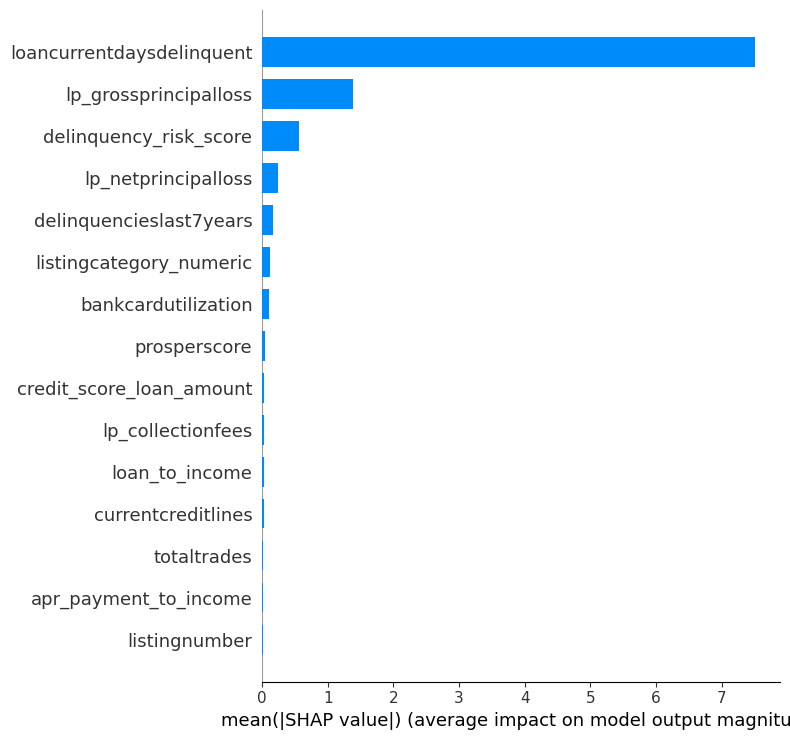

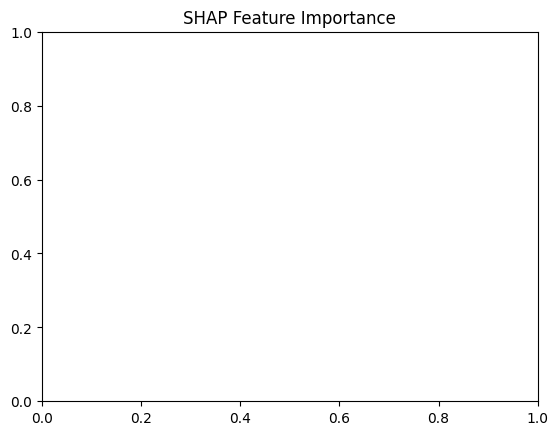

In [19]:
# 8. SHAP Explainability
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15)
plt.title("SHAP Feature Importance")
plt.show()


In [1]:
X.columns.tolist()

NameError: name 'X' is not defined